
In Colab, you can enable the GPU acceleration from `Edit` > `Notebook Settings` > `Accelerator` > `GPU`.

# Silicon diamond tutorial

## Complie [LAMMPS](https://github.com/lammps/lammps) as shared-library of python ($\sim$ 8 min)

In [ ]:
# Sudo apt-get softwares
! apt-get update
! apt install -y cmake build-essential git ccache openmpi-bin libopenmpi-dev python3.7-venv
! echo "Sudo apt-get finishes!"

# Upgrade python packages
! pip install --upgrade pip
! pip install numpy torch scipy virtualenv psutil pandas tabulate mpi4py Cython sklearn
! echo "Python packages installation finishes!"

# Build lammps with cmake
%cd /content
!rm -rf lammps
! git clone https://github.com/lammps/lammps.git lammps
%cd /content/lammps
! rm -rf build
! mkdir build
%cd build
! cmake ../cmake -DLAMMPS_EXCEPTIONS=yes \
               -DBUILD_SHARED_LIBS=yes \
               -DMLIAP_ENABLE_PYTHON=yes \
               -DPKG_PYTHON=yes \
               -DPKG_MANYBODY=yes \
               -DPKG_KSPACE=yes \
               -DPKG_PHONON=yes \
               -DPYTHON_EXECUTABLE:FILEPATH=`which python`

# Complie lammps as share-libary of python
! make -j 2
! make install-python
! echo "LAMMPS compilation done!"

# Redirect back to main folder
%cd /content/

## Remote fetch  and install source code from Github

In [ ]:
! pip install git+https://github.com/nanotheorygroup/kaldo

## Remote fetch supplyment files


In [ ]:
# Remote fetch kaldo resources from drop box
! wget https://www.dropbox.com/s/bvw0qcxy397g25q/kaldo_resources.zip?dl=0
! mv kaldo_resources.zip?dl=0 kaldo_resources.zip
! unzip kaldo_resources.zip

# Unzip files
!unzip forcefields.zip

# Clean workspace
! rm -r forcefields.zip
! rm -r structure_a_si_512.zip
! rm -r kaldo_resources.zip
! rm -r sample_data

## Thermal transport simulation for silicon-bulk

In [ ]:
from ase.build import bulk
from ase.calculators.lammpslib import LAMMPSlib
from kaldo.forceconstants import ForceConstants
import numpy as np

# We start from the atoms object
atoms = bulk('Si', 'diamond', a=5.432)

# Config super cell and calculator input
supercell = np.array([3, 3, 3])
lammps_inputs = {
      'lmpcmds': [
          'pair_style tersoff',
          'pair_coeff * * forcefields/Si.tersoff Si'],

      'log_file': 'lammps-si-bulk.log',
      'keep_alive':True}

# Create a finite difference object
forceconstants_config  = {'atoms':atoms,'supercell': supercell,'folder':'fd'}
forceconstants = ForceConstants(**forceconstants_config)

# Compute 2nd and 3rd IFCs with the defined calculators
forceconstants.second.calculate(LAMMPSlib(**lammps_inputs), delta_shift=1e-3)
forceconstants.third.calculate(LAMMPSlib(**lammps_inputs), delta_shift=1e-3)

### Create phonons object


In [7]:
from kaldo.phonons import Phonons

# Define k-point grids, temperature
# and the assumption for the 
# phonon poluation (i.e classical vs. quantum)
k = 7
kpts = [k, k, k]
temperature = 300
is_classic = False
k_label = str(k) + '_' + str(k) + '_' + str(k)

# Create a phonon object
phonons = Phonons(forceconstants=forceconstants,
                kpts=kpts,
                is_classic=is_classic,
                temperature=temperature,
                folder='si-bulk-ald-' + k_label,
                storage='numpy')

### Calculate conductivities for infinite-size sample


In [8]:
from kaldo.conductivity import Conductivity

# Calculate conductivity  with direct inversion approach (inverse)
print('\n')
inv_cond_matrix = (Conductivity(phonons=phonons, method='inverse').conductivity.sum(axis=0))
print('Inverse conductivity (W/mK): %.3f'%(np.mean(np.diag(inv_cond_matrix))))
print(inv_cond_matrix)

# Calculate conductivity  with  relaxation time approximation (rta)
print('\n')
rta_cond_matrix = Conductivity(phonons=phonons, method='rta').conductivity.sum(axis=0)
print('Rta conductivity (W/mK): %.3f'%(np.mean(np.diag(rta_cond_matrix))))
print(rta_cond_matrix)
# Calculate conductivity  with  self-consistent approach (sc)

print('\n')
sc_cond_matrix = Conductivity(phonons=phonons, method='sc',n_iterations=20).conductivity.sum(axis=0)
print('Self-consistent conductivity (W/mK): %.3f'%(np.mean(np.diag(sc_cond_matrix))))
print(sc_cond_matrix)



2022-10-29 04:56:58,186 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/300/quantum/inverse/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/300/quantum/inverse/conductivity not found in formatted format, calculating conductivity


2022-10-29 04:56:58,193 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/300/quantum/inverse/mean_free_path not found in formatted format, calculating mean_free_path


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/300/quantum/inverse/mean_free_path not found in formatted format, calculating mean_free_path


2022-10-29 04:56:58,198 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/physical_mode not found in numpy format, calculating physical_mode


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/physical_mode not found in numpy format, calculating physical_mode


2022-10-29 04:56:58,215 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/frequency not found in numpy format, calculating frequency


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/frequency not found in numpy format, calculating frequency


2022-10-29 04:57:04,716 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/frequency stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/frequency stored


2022-10-29 04:57:04,722 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/physical_mode stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/physical_mode stored


2022-10-29 04:57:04,730 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/velocity not found in numpy format, calculating velocity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/velocity not found in numpy format, calculating velocity
/usr/local/lib/python3.7/dist-packages/kaldo/observables/harmonic_with_q.py:214: RuntimeWarning: invalid value encountered in sqrt
  inverse_sqrt_freq = tf.cast(tf.convert_to_tensor(1 / np.sqrt(frequency)), tf.complex128)


2022-10-29 04:57:10,992 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/velocity stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/velocity stored


2022-10-29 04:57:10,998 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2022-10-29 04:57:11,002 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2022-10-29 04:57:11,005 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/300/quantum/_ps_gamma_and_gamma_tensor not found in numpy format, calculating _ps_gamma_and_gamma_tensor


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/300/quantum/_ps_gamma_and_gamma_tensor not found in numpy format, calculating _ps_gamma_and_gamma_tensor


2022-10-29 04:57:11,057 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/_eigensystem not found in numpy format, calculating _eigensystem


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/_eigensystem not found in numpy format, calculating _eigensystem


2022-10-29 04:57:12,066 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/_eigensystem stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/_eigensystem stored


2022-10-29 04:57:12,077 - kaldo - INFO - scattering_tensor: [2058 2060] * <class 'float'>


INFO:kaldo:scattering_tensor: [2058 2060] * <class 'float'>


2022-10-29 04:57:12,081 - kaldo - INFO - Memory needed: 33 MB, available: 11284 / 13616 MB


INFO:kaldo:Memory needed: 33 MB, available: 11284 / 13616 MB


2022-10-29 04:57:12,107 - kaldo - INFO - Projection started


INFO:kaldo:Projection started


2022-10-29 04:57:12,111 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/300/quantum/population not found in numpy format, calculating population


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/300/quantum/population not found in numpy format, calculating population


2022-10-29 04:57:12,831 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/300/quantum/population stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/300/quantum/population stored


2022-10-29 04:57:12,839 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2022-10-29 04:57:12,845 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2022-10-29 04:57:12,852 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2022-10-29 04:57:12,858 - kaldo - INFO - Calculating third order projection 0, 0.0%


INFO:kaldo:Calculating third order projection 0, 0.0%


2022-10-29 04:57:19,786 - kaldo - INFO - Calculating third order projection 200, 10.0%


INFO:kaldo:Calculating third order projection 200, 10.0%


2022-10-29 04:57:26,854 - kaldo - INFO - Calculating third order projection 400, 19.0%


INFO:kaldo:Calculating third order projection 400, 19.0%


2022-10-29 04:57:33,967 - kaldo - INFO - Calculating third order projection 600, 28.999999999999996%


INFO:kaldo:Calculating third order projection 600, 28.999999999999996%


2022-10-29 04:57:41,046 - kaldo - INFO - Calculating third order projection 800, 39.0%


INFO:kaldo:Calculating third order projection 800, 39.0%


2022-10-29 04:57:48,185 - kaldo - INFO - Calculating third order projection 1000, 49.0%


INFO:kaldo:Calculating third order projection 1000, 49.0%


2022-10-29 04:57:55,277 - kaldo - INFO - Calculating third order projection 1200, 57.99999999999999%


INFO:kaldo:Calculating third order projection 1200, 57.99999999999999%


2022-10-29 04:58:02,371 - kaldo - INFO - Calculating third order projection 1400, 68.0%


INFO:kaldo:Calculating third order projection 1400, 68.0%


2022-10-29 04:58:09,453 - kaldo - INFO - Calculating third order projection 1600, 78.0%


INFO:kaldo:Calculating third order projection 1600, 78.0%


2022-10-29 04:58:16,918 - kaldo - INFO - Calculating third order projection 1800, 87.0%


INFO:kaldo:Calculating third order projection 1800, 87.0%


2022-10-29 04:58:24,364 - kaldo - INFO - Calculating third order projection 2000, 97.0%


INFO:kaldo:Calculating third order projection 2000, 97.0%


2022-10-29 04:58:26,434 - kaldo - INFO - 'project_crystal'  75.42 s


INFO:kaldo:'project_crystal'  75.42 s


2022-10-29 04:58:26,476 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/300/quantum/_ps_gamma_and_gamma_tensor stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/300/quantum/_ps_gamma_and_gamma_tensor stored


2022-10-29 04:58:26,519 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2022-10-29 04:58:26,526 - kaldo - INFO - Memory needed: 33 MB, available: 11242 / 13616 MB


INFO:kaldo:Memory needed: 33 MB, available: 11242 / 13616 MB


2022-10-29 04:58:26,629 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth not found in numpy format, calculating bandwidth


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth not found in numpy format, calculating bandwidth


2022-10-29 04:58:26,636 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/300/quantum/_ps_and_gamma not found in numpy format, calculating _ps_and_gamma


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/300/quantum/_ps_and_gamma not found in numpy format, calculating _ps_and_gamma


2022-10-29 04:58:26,665 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/_ps_gamma_and_gamma_tensor


2022-10-29 04:58:26,671 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/300/quantum/_ps_and_gamma stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/300/quantum/_ps_and_gamma stored


2022-10-29 04:58:26,683 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth stored


2022-10-29 04:58:27,509 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2022-10-29 04:58:27,523 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2022-10-29 04:58:27,542 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/_ps_gamma_and_gamma_tensor


2022-10-29 04:58:27,562 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2022-10-29 04:58:27,564 - kaldo - INFO - Memory needed: 33 MB, available: 11234 / 13616 MB


INFO:kaldo:Memory needed: 33 MB, available: 11234 / 13616 MB


2022-10-29 04:58:27,640 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:28,407 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2022-10-29 04:58:28,411 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2022-10-29 04:58:28,434 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/_ps_gamma_and_gamma_tensor


2022-10-29 04:58:28,453 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2022-10-29 04:58:28,463 - kaldo - INFO - Memory needed: 33 MB, available: 11234 / 13616 MB


INFO:kaldo:Memory needed: 33 MB, available: 11234 / 13616 MB


2022-10-29 04:58:28,519 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:29,326 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity not found in numpy format, calculating heat_capacity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity not found in numpy format, calculating heat_capacity


2022-10-29 04:58:30,087 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity stored


2022-10-29 04:58:30,093 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2022-10-29 04:58:30,100 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2022-10-29 04:58:30,108 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


Inverse conductivity (W/mK): 290.827
[[292.42153862   4.57165775  -0.53825504]
 [  4.66520595 289.25386952  -0.52648865]
 [ -0.52326161  -0.46772834 290.80473205]]


2022-10-29 04:58:30,167 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/300/quantum/rta/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/300/quantum/rta/conductivity not found in formatted format, calculating conductivity


2022-10-29 04:58:30,175 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/300/quantum/rta/mean_free_path not found in formatted format, calculating mean_free_path


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/300/quantum/rta/mean_free_path not found in formatted format, calculating mean_free_path


2022-10-29 04:58:30,182 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2022-10-29 04:58:30,187 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2022-10-29 04:58:30,189 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:30,218 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


2022-10-29 04:58:30,222 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2022-10-29 04:58:30,229 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2022-10-29 04:58:30,232 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


Rta conductivity (W/mK): 258.270
[[259.69187161   3.58836702  -0.90834752]
 [  3.58836702 256.85613244  -0.82038562]
 [ -0.90834752  -0.82038562 258.26161148]]


2022-10-29 04:58:30,293 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/300/quantum/sc/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/300/quantum/sc/conductivity not found in formatted format, calculating conductivity


2022-10-29 04:58:30,298 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/300/quantum/sc/mean_free_path not found in formatted format, calculating mean_free_path


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/300/quantum/sc/mean_free_path not found in formatted format, calculating mean_free_path


2022-10-29 04:58:30,305 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2022-10-29 04:58:30,311 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2022-10-29 04:58:30,316 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2022-10-29 04:58:30,323 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2022-10-29 04:58:30,344 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/_ps_gamma_and_gamma_tensor


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/_ps_gamma_and_gamma_tensor


2022-10-29 04:58:30,363 - kaldo - INFO - _scattering_matrix: [2055 2055] * <class 'float'>


INFO:kaldo:_scattering_matrix: [2055 2055] * <class 'float'>


2022-10-29 04:58:30,368 - kaldo - INFO - Memory needed: 33 MB, available: 11268 / 13616 MB


INFO:kaldo:Memory needed: 33 MB, available: 11268 / 13616 MB


2022-10-29 04:58:30,413 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:30,422 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


2022-10-29 04:58:30,431 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:30,447 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


2022-10-29 04:58:30,457 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:30,488 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


2022-10-29 04:58:30,494 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:30,513 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


2022-10-29 04:58:30,519 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:30,540 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


2022-10-29 04:58:30,546 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:30,563 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


2022-10-29 04:58:30,573 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:30,589 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


2022-10-29 04:58:30,597 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:30,615 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


2022-10-29 04:58:30,620 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:30,640 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


2022-10-29 04:58:30,645 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:30,665 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


2022-10-29 04:58:30,683 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:30,722 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


2022-10-29 04:58:30,729 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:30,750 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


2022-10-29 04:58:30,757 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:30,780 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


2022-10-29 04:58:30,793 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:30,815 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


2022-10-29 04:58:30,829 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:30,843 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


2022-10-29 04:58:30,857 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:30,880 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


2022-10-29 04:58:30,892 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:30,909 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


2022-10-29 04:58:30,920 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:30,938 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


2022-10-29 04:58:30,949 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:30,966 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


2022-10-29 04:58:30,977 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:30,995 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


2022-10-29 04:58:31,006 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:58:31,024 - kaldo - INFO - Number of self-consistent iterations: 19


INFO:kaldo:Number of self-consistent iterations: 19


2022-10-29 04:58:31,063 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


2022-10-29 04:58:31,072 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/velocity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/velocity


2022-10-29 04:58:31,081 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2022-10-29 04:58:31,085 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


Self-consistent conductivity (W/mK): 290.827
[[292.42153842   4.57165769  -0.53825507]
 [  4.66520589 289.25386935  -0.52648868]
 [ -0.52326165  -0.46772837 290.80473188]]


### Visualize harmonic properties using built-in plotter


/usr/local/lib/python3.7/dist-packages/kaldo/observables/harmonic_with_q.py:214: RuntimeWarning: invalid value encountered in sqrt
  inverse_sqrt_freq = tf.cast(tf.convert_to_tensor(1 / np.sqrt(frequency)), tf.complex128)


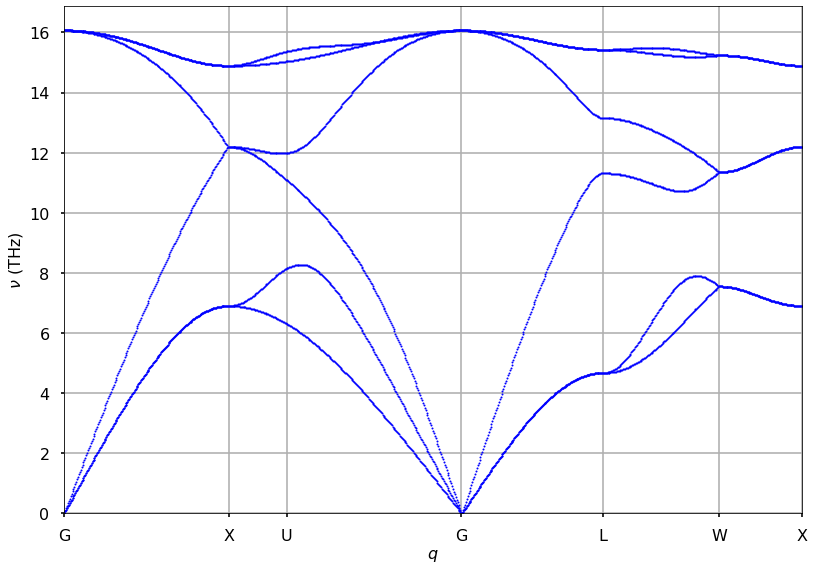

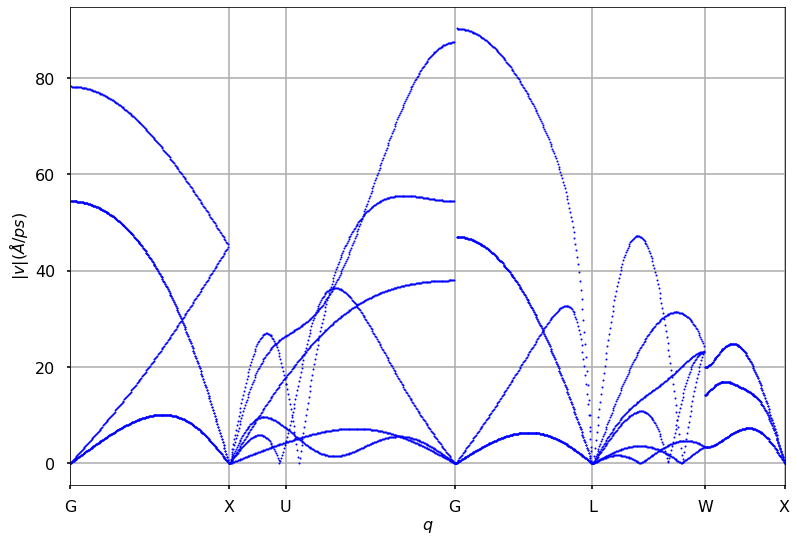

In [9]:
import kaldo.controllers.plotter as plotter
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')

# Plot dispersion relation and group velocity in each direction
plotter.plot_dispersion(phonons,n_k_points=int(k_label))
print('\n')

### Access and visualize properties calculated during simulations

2022-10-29 04:58:58,935 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2022-10-29 04:58:58,943 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/heat_capacity


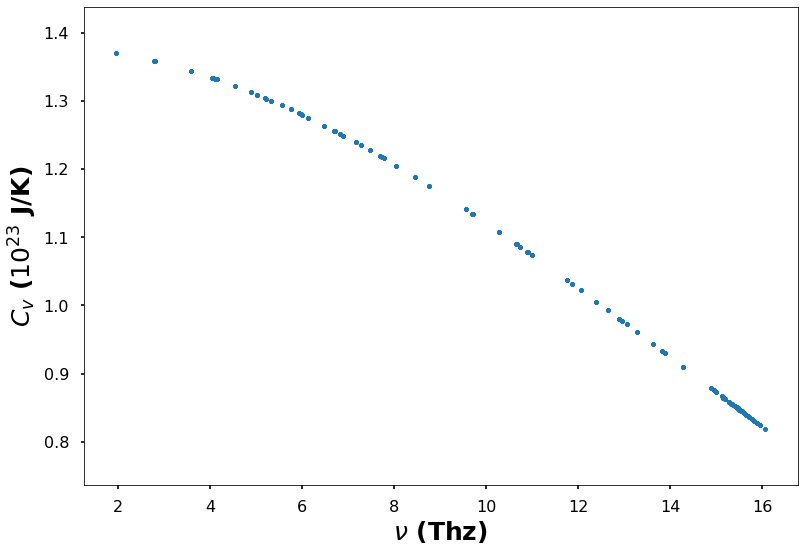

2022-10-29 04:58:59,126 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


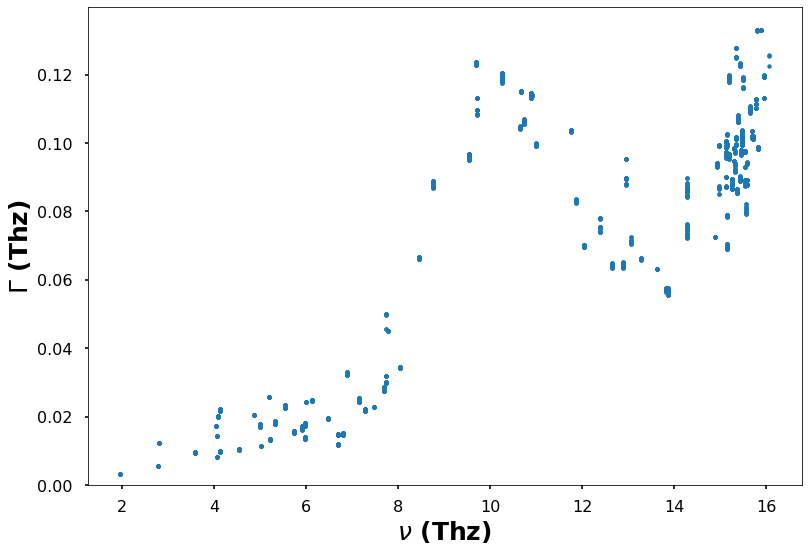



2022-10-29 04:58:59,274 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/300/quantum/phase_space not found in numpy format, calculating phase_space


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/300/quantum/phase_space not found in numpy format, calculating phase_space


2022-10-29 04:58:59,278 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/_ps_and_gamma


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/_ps_and_gamma


2022-10-29 04:58:59,281 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/300/quantum/phase_space stored


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/300/quantum/phase_space stored


2022-10-29 04:58:59,308 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/phase_space


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/phase_space


2022-10-29 04:58:59,314 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/phase_space


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/phase_space


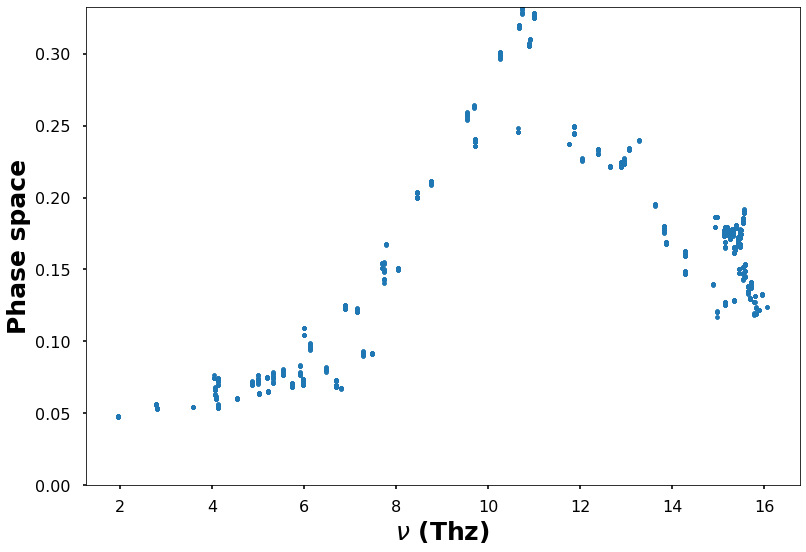

In [10]:
# Direct access to properties
# calculated during the simulation

# Plot heat capacity vs frequency
freq_full = phonons.frequency.flatten(order='C')
cv_1d = phonons.heat_capacity.flatten(order='C')[3:]

print('\n')
plt.figure()
plt.scatter(freq_full[3:],1e23*cv_1d,s=15)
plt.ylabel (r"$C_{v}$ ($10^{23}$ J/K)", fontsize=25, fontweight='bold')
plt.xlabel ("$\\nu$ (Thz)", fontsize=25, fontweight='bold')
plt.ylim(0.9*1e23*cv_1d[cv_1d>0].min(), 
         1.05*1e23*cv_1d.max())
plt.show()

# Plot phonon bandwidth vs frequency
band_width_flatten = phonons.bandwidth.flatten(order='C')
freq = freq_full[band_width_flatten!=0]

print('\n')
plt.figure()
plt.scatter(freq,band_width_flatten[band_width_flatten!=0] ,s=15)
plt.ylabel (r"$\Gamma$ (Thz)", fontsize=25, fontweight='bold')
plt.xlabel ("$\\nu$ (Thz)", fontsize=25, fontweight='bold')
plt.ylim(0.95*band_width_flatten .min(), 1.05*band_width_flatten .max())
plt.show()

# Plot phase space vs frequency
print('\n')
plt.figure()
plt.scatter(freq_full[3:],phonons.phase_space.flatten(order='C')[3:],s=15)
plt.ylabel ("Phase space", fontsize=25, fontweight='bold')
plt.xlabel ("$\\nu$ (Thz)", fontsize=25, fontweight='bold')
plt.ylim(phonons.phase_space.min(), phonons.phase_space.max())
plt.show()

### Calculate and visualize $\kappa_{per \ mode}$ and $\kappa_{cum}$

In [11]:
def cumulative_cond_cal(freq,full_cond,n_phonons):

  conductivity = np.einsum('maa->m', 1/3 * full_cond)
  conductivity = conductivity.reshape(n_phonons)
  cumulative_cond = np.zeros_like(conductivity)
  freq_reshaped = freq.reshape(n_phonons)

  for mu in range(cumulative_cond.size):
      single_cumulative_cond = conductivity[(freq_reshaped < freq_reshaped[mu])].sum()
      cumulative_cond[mu] = single_cumulative_cond
  
  return cumulative_cond

2022-10-29 04:59:08,048 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/rta/conductivity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/rta/conductivity


2022-10-29 04:59:08,115 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/inverse/conductivity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/inverse/conductivity


2022-10-29 04:59:08,185 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/sc/conductivity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/sc/conductivity


2022-10-29 04:59:08,188 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2022-10-29 04:59:08,260 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/rta/conductivity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/rta/conductivity


2022-10-29 04:59:08,287 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2022-10-29 04:59:08,354 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/sc/conductivity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/sc/conductivity


2022-10-29 04:59:08,383 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2022-10-29 04:59:08,455 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/inverse/conductivity


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/inverse/conductivity


2022-10-29 04:59:08,480 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2022-10-29 04:59:08,488 - kaldo - INFO - si-bulk-ald-7_7_7/7_7_7/300/quantum/qhgk/conductivity not found in formatted format, calculating conductivity


INFO:kaldo:si-bulk-ald-7_7_7/7_7_7/300/quantum/qhgk/conductivity not found in formatted format, calculating conductivity


2022-10-29 04:59:08,495 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/frequency


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/frequency


2022-10-29 04:59:08,501 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/physical_mode


2022-10-29 04:59:08,507 - kaldo - INFO - Using Lorentzian diffusivity_shape


INFO:kaldo:Using Lorentzian diffusivity_shape


2022-10-29 04:59:08,510 - kaldo - INFO - Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


INFO:kaldo:Loading si-bulk-ald-7_7_7/7_7_7/300/quantum/bandwidth


2022-10-29 04:59:08,512 - kaldo - INFO - Start calculation diffusivity


INFO:kaldo:Start calculation diffusivity
/usr/local/lib/python3.7/dist-packages/kaldo/controllers/dirac_kernel.py:26: RuntimeWarning: invalid value encountered in true_divide
  lorentzian = 1 / np.pi * 1 / 2 * sigma / (delta_omega ** 2 + (sigma / 2) ** 2)


2022-10-29 04:59:17,257 - kaldo - INFO - Conductivity calculated


INFO:kaldo:Conductivity calculated


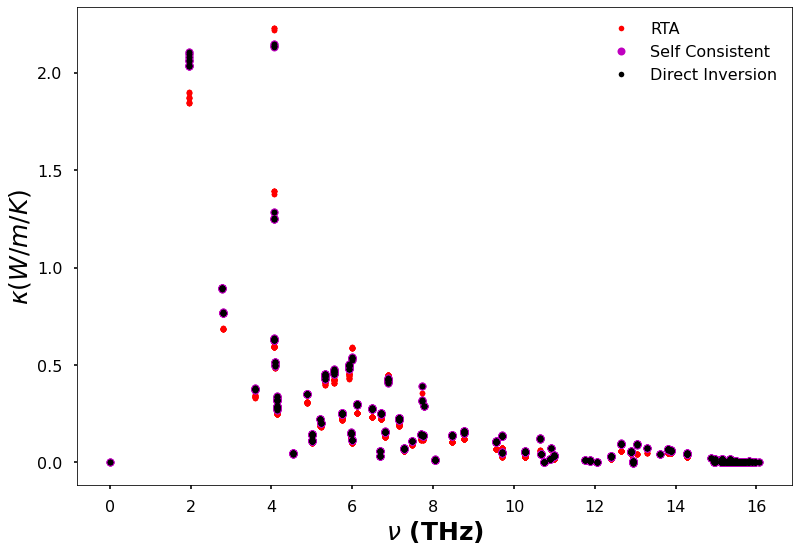

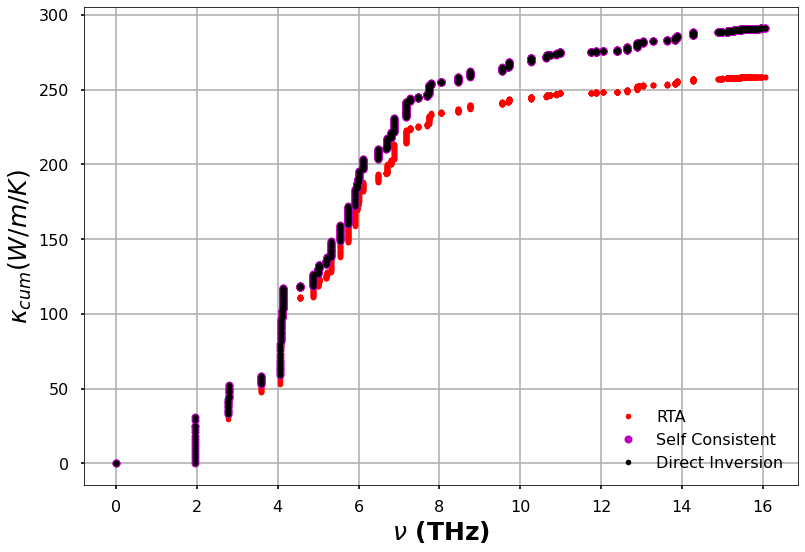

In [12]:
# Compute conductivity with per phonon mode basis using different methods
kappa_rta_per_mode = np.einsum('maa->m',1/3*Conductivity(phonons=phonons, method='rta').conductivity)
kappa_inv_per_mode = np.einsum('maa->m',1/3*Conductivity(phonons=phonons, method='inverse').conductivity)
kappa_sc_per_mode = np.einsum('maa->m',1/3*Conductivity(phonons=phonons, method='sc',n_iterations=20).conductivity)

# Compute cumulative conductivity by frequency using different methods
kappa_rta_cum_freq = cumulative_cond_cal(phonons.frequency,Conductivity(phonons=phonons, method='rta').conductivity,phonons.n_phonons)
kappa_sc_cum_freq = cumulative_cond_cal(phonons.frequency,Conductivity(phonons=phonons, method='sc',n_iterations=20).conductivity,phonons.n_phonons)
kappa_inv_cum_freq = cumulative_cond_cal(phonons.frequency,Conductivity(phonons=phonons, method='inverse').conductivity,phonons.n_phonons)
kappa_qhgk_cum_freq = cumulative_cond_cal(phonons.frequency,Conductivity(phonons=phonons, method='qhgk').conductivity,phonons.n_phonons)
print('\n')

# Visualize the cumulative conductivity vs frequency
plt.figure()
plt.plot(freq_full,kappa_rta_per_mode,'r.',label='RTA')
plt.plot(freq_full,kappa_sc_per_mode,'mo',label='Self Consistent',ms=8)
plt.plot(freq_full,kappa_inv_per_mode,'k.',label='Direct Inversion')
plt.xlabel ("$\\nu$ (THz)", fontsize=25, fontweight='bold')
plt.ylabel(r'$\kappa(W/m/K)$', fontsize=25, fontweight='bold')
plt.legend(loc=1,frameon=False)
#plt.grid()
plt.show()
print('\n')

# Visualize the cumulative conductivity vs frequency
plt.figure()
plt.plot(freq_full,kappa_rta_cum_freq,'r.',label='RTA')
plt.plot(freq_full,kappa_sc_cum_freq,'mo',label='Self Consistent',ms=8)
plt.plot(freq_full,kappa_inv_cum_freq,'k.',label='Direct Inversion')
plt.xlabel ("$\\nu$ (THz)", fontsize=25, fontweight='bold')
plt.ylabel(r'$\kappa_{cum}(W/m/K)$', fontsize=25, fontweight='bold')
plt.legend(loc=4,frameon=False)
plt.grid()
plt.show()